# Order pattern for Black Echelle in LHD

## Imports and Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.signal import savgol_filter
import peakutils
import numpy as np
import plotly.graph_objects as go

%matplotlib inline

In [2]:
# Don't know how to import locally, so I just use %run
%run ../src/echelle_spectra/tools/echelle.py

In [3]:
files_cmos_2024 = {
    "orders": "pattern_cmos.txt",
    "wavelength": "Th_wavelength_CMOS.txt",
    "sphr": "sphere_CMOS_20240305.sif",
    "bkgr": "sphere_CMOS_20240305_bkg.sif",
    "integral": "integrating_sphere.txt",
}
bpth = '../src/echelle_spectra/resources/calibration_files'

In [4]:
cb = Calibrations(folder=bpth, filenames=files_cmos_2024)
cb.load_sphere()
sph = cb.sphr.images.sum(axis=0)/cb.sphr.info['NumberOfFrames']
bkg = cb.bkgr.images.sum(axis=0)/cb.bkgr.info['NumberOfFrames']

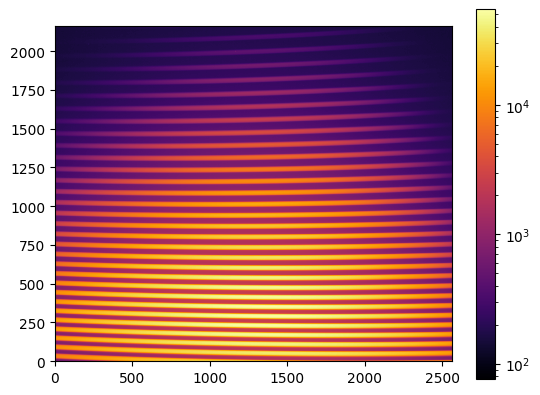

In [5]:
img = sph
norm=mpl.colors.LogNorm(img.min()*1,img.max()*1)
im = plt.imshow(img,cmap='inferno',norm=norm,aspect=1,origin='lower')
plt.colorbar(im)

In [6]:
nx,ny = cb.DIMO,cb.DIMW
xpixels = np.arange(nx)
ypixels = np.arange(ny)

### Smooth signal

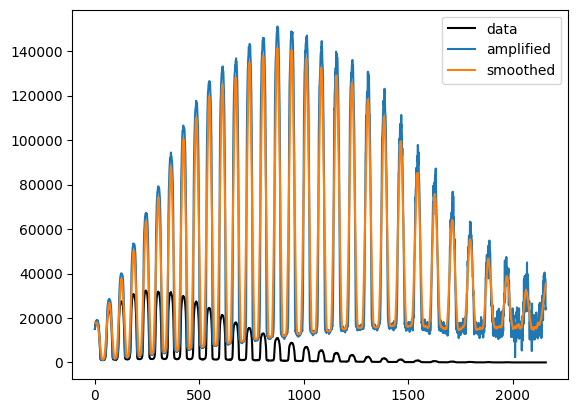

In [7]:
img = sph-bkg

slice_y_at = 550
y=img[:,slice_y_at]
y_smoothed = savgol_filter(y, 21, 1)
amp = np.exp(3e-3 * xpixels) # amplify weak signal for higher orders
plt.plot(y, 'k',label='data')
plt.plot(y * amp,label='amplified')
plt.plot(y_smoothed * amp,label='smoothed')
plt.legend()

In [8]:
yprep = y_smoothed*amp
# calculate baseline
base = peakutils.baseline(yprep, 6)
# adjust parameters for correct peak detection
ind = peakutils.indexes(yprep-base, thres=.13, min_dist=50)

fig = go.Figure()

fig.add_trace(go.Scatter(x=xpixels, y=yprep, mode='lines',name='slice'))
fig.add_trace(go.Scatter(x=ind,y=yprep[ind],mode='markers',name='peaks'))
fig.add_trace(go.Scatter(x=xpixels,y=base,mode='lines',name='base'))
fig.show()

In [9]:
def set_slices(vect,step_size=100,num_steps = 8):
    center_index = len(vect)// 2
    start_index = center_index - (num_steps // 2 * step_size)
    end_index = start_index + (num_steps * step_size)
    print(center_index,len(vect))
    return vect[start_index:end_index:step_size]

def fit_pattern(peaks,yselect,ypixels):
    """ Do polinomial fit for all orders """
    pat_y = np.array(peaks)
    # fit quadratics
    fits = [np.poly1d(np.polyfit(yselect, i, 2)) for i in pat_y.T]
    x = ypixels    
    pattern = np.array([f(x) for f in fits], dtype=int)
    return pattern

1280 2560


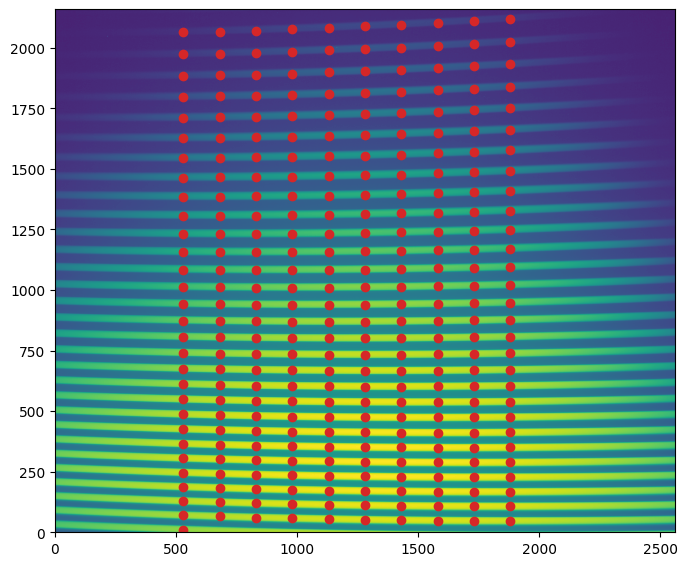

In [10]:
yselect = set_slices(np.arange(ny),step_size=150,num_steps=10)

peaks = []
pvals = []
for yind in yselect:
    y=img[:, yind]
    amp = np.exp(3e-3 * xpixels) 
    ysm = savgol_filter(y, 21, 1)*amp
    base = peakutils.baseline(ysm, 6)
    ind = peakutils.indexes(ysm - base, thres=.13, min_dist=50)
    peaks.append(ind)
    pvals.append(ysm[ind])

dimg = sph # to avoid log of negative with background subtraction
norm=mpl.colors.LogNorm(dimg.min(), dimg.max() * 1)
plt.imshow(dimg, origin="lower", cmap="viridis",norm=norm)

# plot peaks
for ind,py in zip(peaks, yselect):
    x = np.ones(ind.shape[0]) * py
    plt.plot(x, ind, 'oC3')

#plt.plot(x, ind, 'oC4')

plt.gcf().set_size_inches([8, 8])

# Manual correction

In [11]:
manual_peaks = peaks.copy()
manual_peaks[0]=peaks[0][1:]

# Fit corrected peaks data

In [12]:
pattern = fit_pattern(manual_peaks,yselect,ypixels)

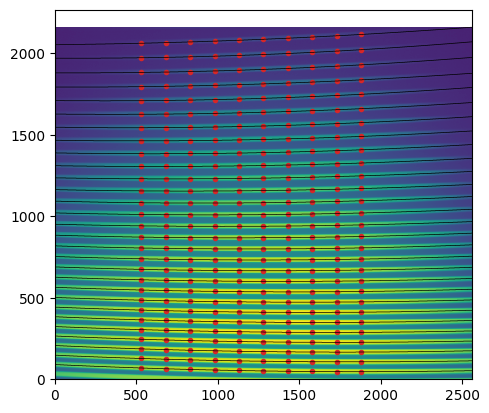

In [13]:
dimg = sph # to avoid log of negative with background subtraction
norm=mpl.colors.LogNorm(dimg.min(), dimg.max() * 1)
plt.imshow(dimg, origin="lower", cmap="viridis",norm=norm)

for ind,py in zip(manual_peaks, yselect):
    x = np.ones(ind.shape[0]) * py
    plt.plot(x, ind, '.C3')

for p in pattern:
    plt.plot(p, 'k',lw=0.5)


# Save pattern file

In [14]:
tosave = False

if tosave:
    np.savetxt('pattern_CMOS_20240305.txt', pattern.T, fmt='%.d')